In [49]:
%%capture
!pip install tensorflow_addons

In [50]:
from zipfile import ZipFile
import pandas as pd
import os, time
import shutil
import sys
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow import keras
import random

In [51]:
#Set seed value
seed_value = 43

os.environ['PYTHONHASHSEED'] = str(seed_value)

random.seed(seed_value)

#numpy seed
np.random.seed(seed_value)

#Tf seed
tf.random.set_seed(seed_value)

#Configure new global tensorflow session
from tensorflow.compat.v1.keras import backend as k
session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads = 1,
    inter_op_parallelism_threads = 1
)

sess = tf.compat.v1.Session(graph = tf.compat.v1.get_default_graph(), config = session_conf)
k.set_session(sess)

In [52]:
#Hyper params
split = 0.8
height, width = 240, 320 

In [53]:
train_df = pd.read_csv('../input/nyu-depth-v2/nyu_data/data/nyu2_train.csv',header=None)
test = pd.read_csv('../input/nyu-depth-v2/nyu_data/data/nyu2_train.csv',header=None).rename(columns={0:'image', 1:'depth'})
train_df = train_df.sample(frac=1).reset_index(drop=True).rename(columns={0:'image', 1:'depth'})
train_split = int(len(train_df)*split)


train = train_df[:train_split]
validation = train_df[train_split:]
len(train), len(validation)

(40550, 10138)

In [54]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, dataframe, batch_size, shuffle=False, dim=(width,height)):
    # for reproducibility
    np.random.seed(43)
    # dataframe containing the subset of image and depth pairs
    self.df = dataframe
    # chosen Height and Width of the RGB image
    self.height, self.width = dim
    # choice of shuffling the data
    self.shuffle = shuffle
    self.batch_size = batch_size
    # unique set of RGB images
    self.ids = dataframe['image'].unique()
    # Map the image with depth maps
    self.imgtodpth = dataframe.set_index('image')['depth'].to_dict()
    self.on_epoch_end()

  def __len__(self):
    '''
    Returns the length of dataset.
    '''
    return len(self.df) // self.batch_size

  def on_epoch_end(self):
    '''
    Shuffles the data at the end of every epoch
    '''
    self.indexes = np.arange(len(self.ids))
    if self.shuffle:
      np.random.shuffle(self.indexes)
  
  def __getitem__(self,index):
    '''
    returns the batch of image and depth pairs 
    '''
    # select the batch of pair indexes 
    idxs = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
    # randomly select whether to flip the image
    flip = np.random.choice([True, False])
    # select the image id's for the above indexes
    query_imgs = [self.ids[idx] for idx in idxs]
    # select corresponding depth pair for the image
    target_imgs = [self.imgtodpth[img] for img in query_imgs]
    # preprocess the image 
    processed_query_img = self._preprocess_image(query_imgs, flip)
    # preprocess the depth map
    processed_depth_img = self._preprocess_depth(target_imgs, flip)
    return processed_query_img, processed_depth_img

  def _preprocess_image(self,images, flip):
    '''
    Resize, Normalize and randomly Augments the image set. 
    '''
    # placeholder for storing the processed images
    processed = []
    for img in images:
      # resize the image to 640x480
      resized_img = cv2.resize(cv2.imread(os.path.join("../input/nyu-depth-v2/nyu_data",img)),(self.height,self.width)).astype(np.float32)
      # normalize the image to {0,1}
      scaled_img = (resized_img - resized_img.min()) / (resized_img.max() - resized_img.min())
      # flip the image horizontally
      if flip:
        scaled_img = cv2.flip(scaled_img, 1)
      # finally append each image
      processed.append(scaled_img)
    return np.array(processed)

  def _preprocess_depth(self,images, flip):
    '''
    Resize, Normalize and randomly Augments the depth maps.
    '''
    # placeholder for storing the processed depth maps
    processed = []
    for img in images:
      # resize the depth map to 320x240
      resized_img = cv2.resize(cv2.cvtColor(cv2.imread(os.path.join("../input/nyu-depth-v2/nyu_data",img)), cv2.COLOR_BGR2GRAY),(width//2,height//2)).astype(np.float32)
      # normalize it to range {0,1}
      scaled_img = (resized_img - resized_img.min()) / (resized_img.max() - resized_img.min())
      # flip the image horizontally
      if flip:
        scaled_img = cv2.flip(scaled_img, 1)
      # add the color channel as cv2 grayscale image doesnt contain color channel but tensorflow expects it
      scaled_img = np.expand_dims(scaled_img, axis=-1)
      # finally append the image
      processed.append(scaled_img)
    return np.array(processed)
    


In [55]:
train_generator = DataGenerator(train, batch_size=8, shuffle=True, dim=(width, height))
val_generator = DataGenerator(validation, batch_size=8, shuffle=False, dim=(width,height))
test_generator = DataGenerator(test, batch_size=16, shuffle=False, dim=(width, height))
print(len(train_generator), len(val_generator), len(test_generator))

5068 1267 3168


In [56]:
images,depths = next(iter(val_generator))
print(images.shape, depths.shape)

(8, 240, 320, 3) (8, 120, 160, 1)


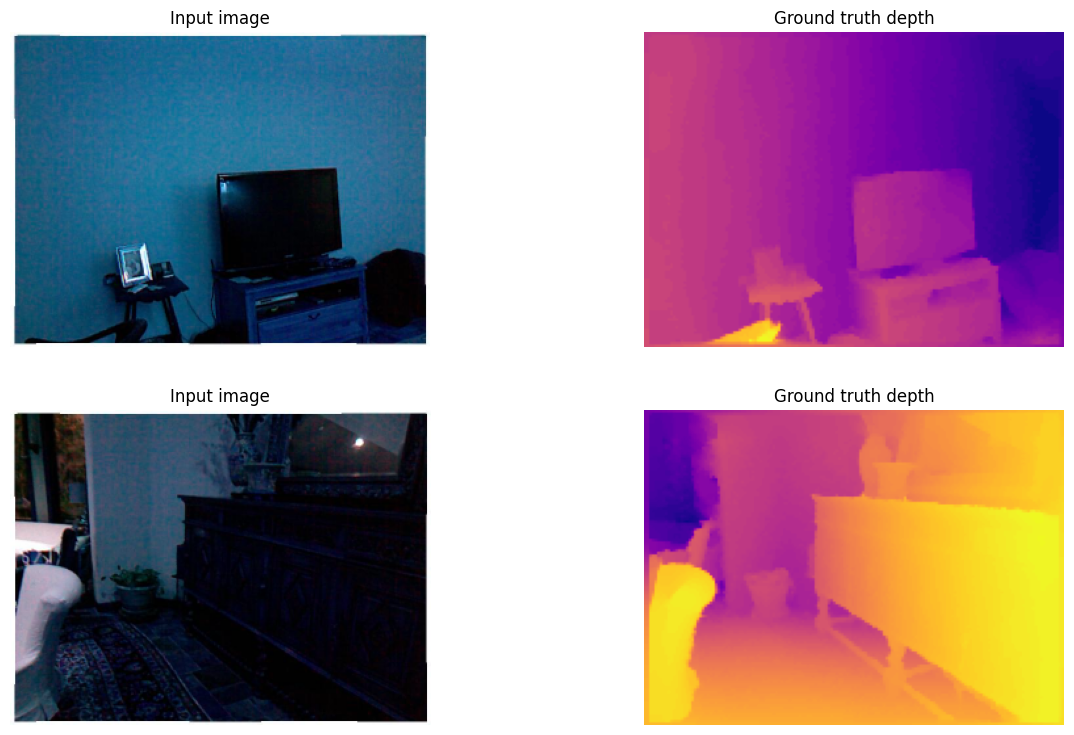

In [57]:
cmap = "plasma_r"
plt.figure(figsize=(15,9))
for i in range(0,4,2):
  image = images[i]
  depth = depths[i].squeeze(-1)
  plt.subplot(221+i)
  plt.axis('off')
  plt.imshow(image)
  plt.title('Input image')
  plt.subplot(222+i)
  plt.axis('off')
  plt.imshow(depth,cmap=plt.get_cmap(cmap))
  plt.title('Ground truth depth')

In [58]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import DepthwiseConv2D, Conv2D, UpSampling2D, Concatenate, Input
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, ReLU
from tensorflow.keras.models import Model

# Definir el nuevo tamaño de entrada (mitad del original)
input_shape = (height, width, 3)

# Cargar el modelo MobileNetV2 como encoder hasta block_13_expand_relu
base_encoder = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet', layers=tf.keras.layers, input_tensor=Input(shape=input_shape))
encoder_output = base_encoder.get_layer('block_13_expand_relu').output

# Bloque bottle neck
bneck = DepthwiseConv2D(kernel_size=(1, 1), padding='same')(encoder_output)
x = ReLU()(bneck)

# Decoder blocks con ajustes para el nuevo tamaño de entrada
def upsampling(input_tensor, skip_tensor, n_filters):
    x = UpSampling2D(size=(2, 2), interpolation='bilinear')(input_tensor)
    x = Concatenate()([x, skip_tensor])
    x = DepthwiseConv2D(kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=n_filters, kernel_size=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    return LeakyReLU(alpha=0.2)(x)

# Reduce el número de canales de salida en las capas de upsampling
x = upsampling(bneck, base_encoder.get_layer('block_6_expand_relu').output, 16)
x = upsampling(x, base_encoder.get_layer('block_3_expand_relu').output, 12)
x = upsampling(x, base_encoder.get_layer('block_1_expand_relu').output, 8)

# Capa de salida
output = Conv2D(filters=1, activation='sigmoid', kernel_size=(3, 3), padding='same')(x)

# Crear el modelo
model = Model(inputs=base_encoder.input, outputs=output)

# Resumen del modelo
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 240, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 120, 160, 32  864         ['input_16[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 120, 160, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [59]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.losses import mean_absolute_error

def loss_function(y_true, y_pred):

  #Cosine distance loss
  l_depth = K.mean(K.abs(y_pred - y_true), axis=-1)
  
  # edge loss for sharp edges
  dy_true, dx_true = tf.image.image_gradients(y_true)
  dy_pred, dx_pred = tf.image.image_gradients(y_pred)
  l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)
  
  # structural similarity loss
  l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, 1.0)) * 0.5, 0, 1)

  # weightage
  w1, w2, w3 = 1.0, 1.0, 0.1
  return (w1 * l_ssim) + (w2 * K.mean(l_edges)) + (w3 * K.mean(l_depth))



#optimizer
opt = tfa.optimizers.AdamW(learning_rate=0.0001, weight_decay=1e-6,amsgrad=True)

# accuracy function
def accuracy_function(y_true, y_pred):
  return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

# save model frequently for later use.
checkpoint = tf.keras.callbacks.ModelCheckpoint('/kaggle/working/project/densenet_final',
                                                save_best_only=True,
                                                verbose=1)
# Learning rate scheduler
def polynomial_decay(epoch):
  max_epochs = 10
  base_lr =  0.0001
  power = 1.0
  lr = base_lr * (1 - (epoch / float(max_epochs))) ** power
  return lr

callbacks = [checkpoint]


def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)


In [60]:
for layer in base_encoder.layers:
  layer.trainable = True
  print(layer.trainable)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [61]:
model.compile(optimizer=opt, loss=loss_function, metrics=[accuracy_function, mae, mse])
history = model.fit(train_generator, validation_data=val_generator, epochs=5,callbacks=callbacks)

Epoch 1/5
5068/5068 [==============================] - ETA: 0s - loss: 0.2156 - accuracy_function: 0.7906 - mae: 0.1445 - mse: 0.0346
Epoch 1: val_loss improved from inf to 0.17252, saving model to /kaggle/working/project/densenet_final
5068/5068 [==============================] - 1565s 307ms/step - loss: 0.2156 - accuracy_function: 0.7906 - mae: 0.1445 - mse: 0.0346 - val_loss: 0.1725 - val_accuracy_function: 0.8087 - val_mae: 0.1306 - val_mse: 0.0296
Epoch 2/5
5068/5068 [==============================] - ETA: 0s - loss: 0.1602 - accuracy_function: 0.8430 - mae: 0.1130 - mse: 0.0229
Epoch 2: val_loss improved from 0.17252 to 0.15117, saving model to /kaggle/working/project/densenet_final
5068/5068 [==============================] - 657s 130ms/step - loss: 0.1602 - accuracy_function: 0.8430 - mae: 0.1130 - mse: 0.0229 - val_loss: 0.1512 - val_accuracy_function: 0.8514 - val_mae: 0.1071 - val_mse: 0.0216
Epoch 3/5
5068/5068 [==============================] - ETA: 0s - loss: 0.1485 - acc

In [62]:
model.evaluate(test_generator)

3168/3168 [==============================] - 565s 178ms/step - loss: 0.1303 - accuracy_function: 0.8876 - mae: 0.0841 - mse: 0.0136


[0.13033467531204224,
 0.8875945210456848,
 0.08411777019500732,
 0.013579433783888817]

In [63]:
images,labels = next(iter(test_generator))
preds = model.predict(images)

1/1 [==============================] - 1s 878ms/step


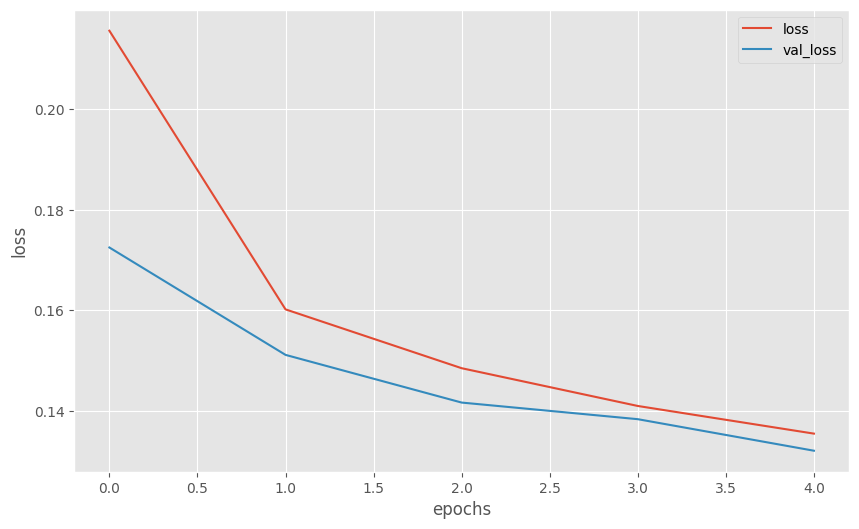

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
# using the style for the plot
plt.style.use('ggplot')
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(figsize=(10, 6))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

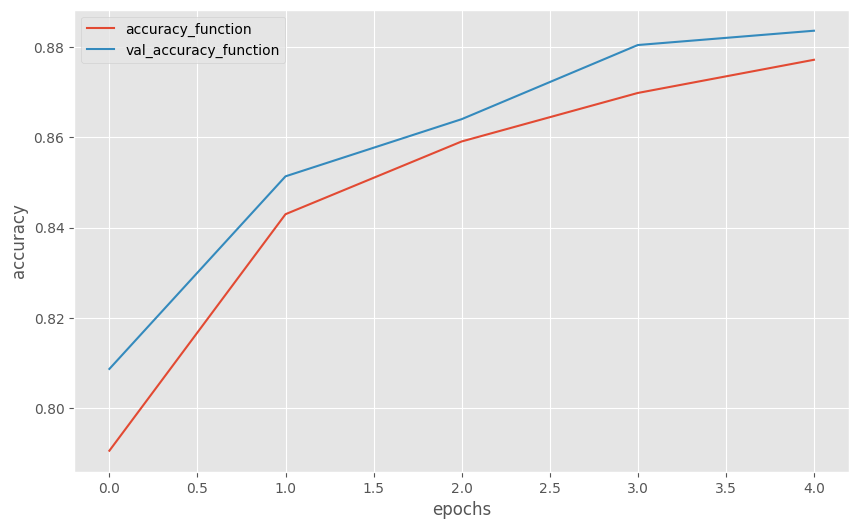

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history)[['accuracy_function', 'val_accuracy_function']].plot(figsize=(10, 6))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

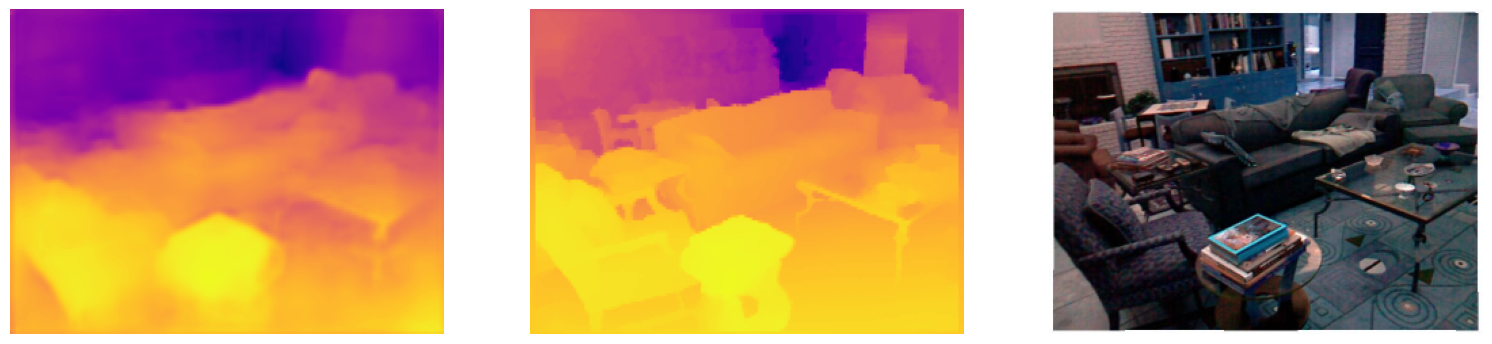

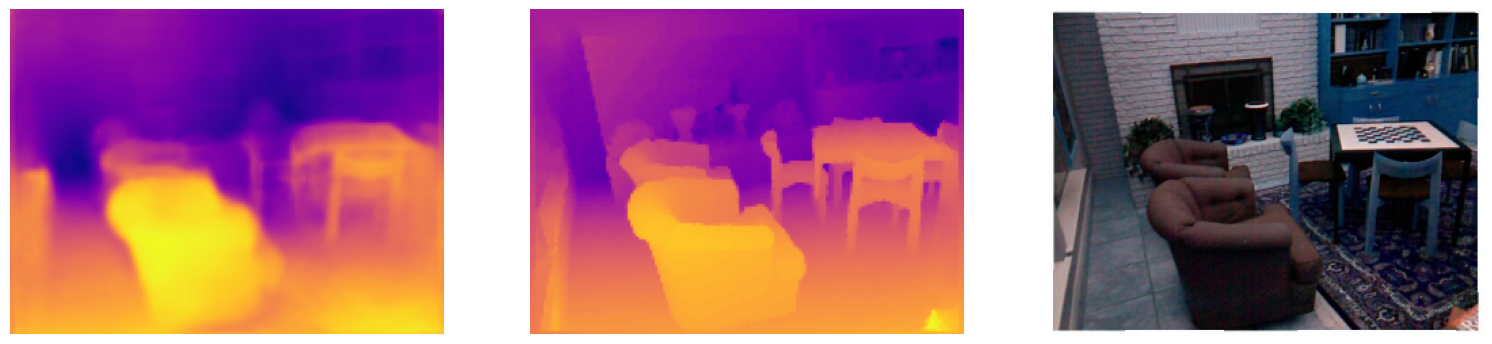

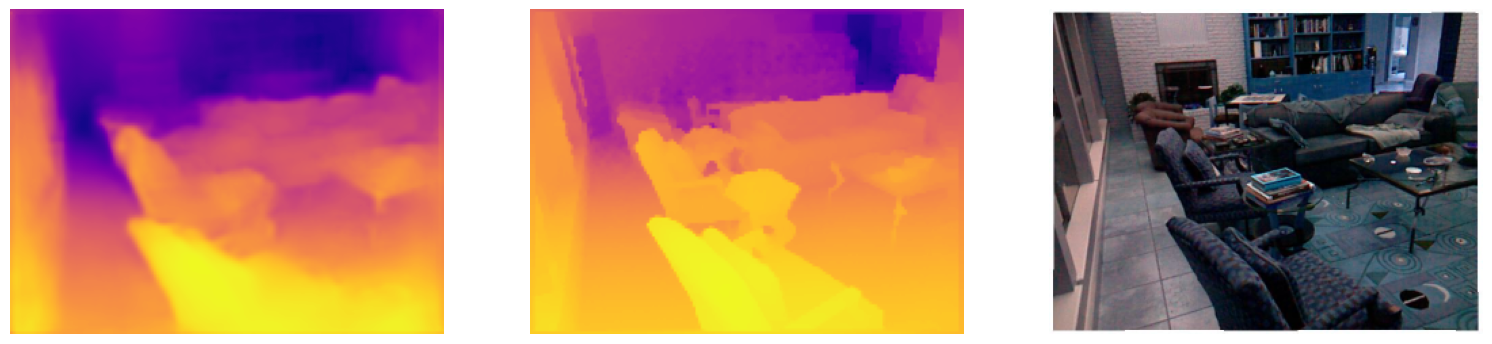

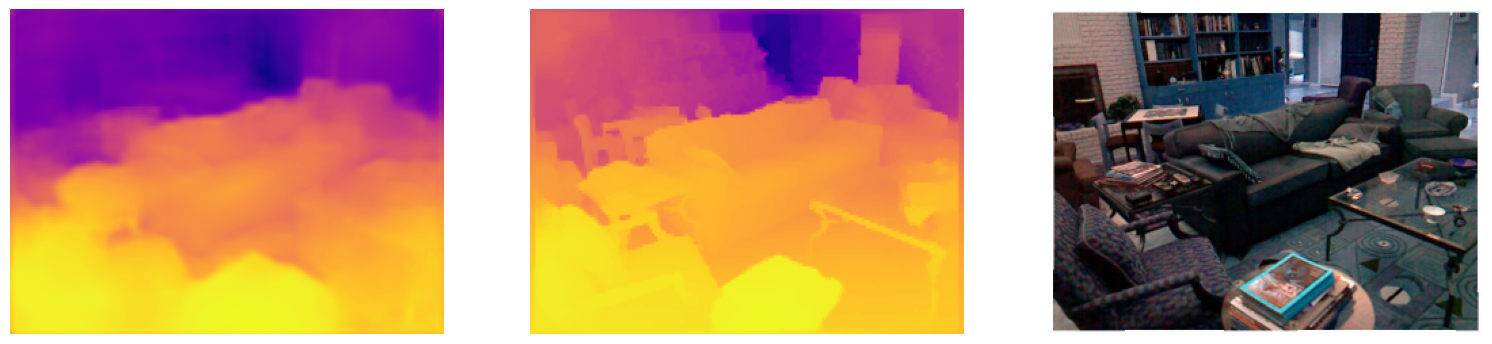

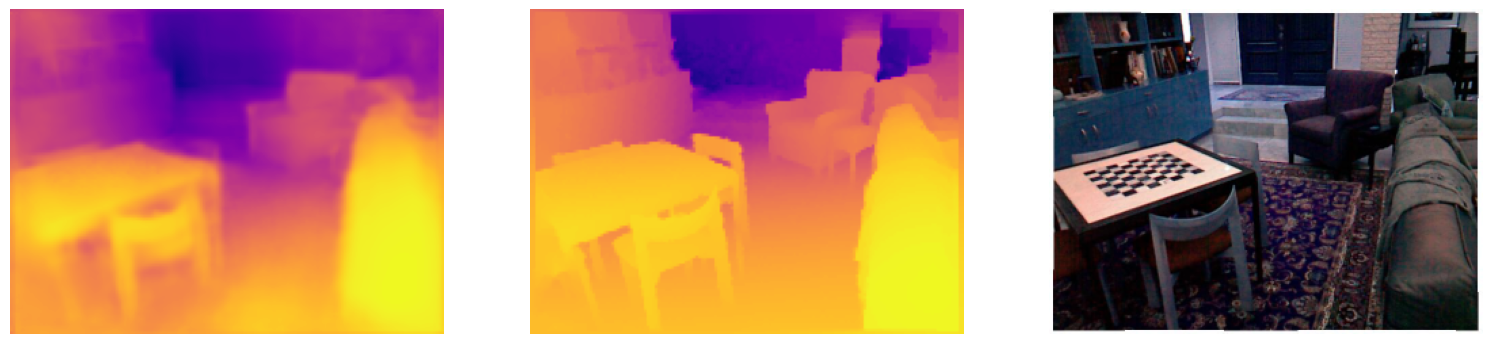

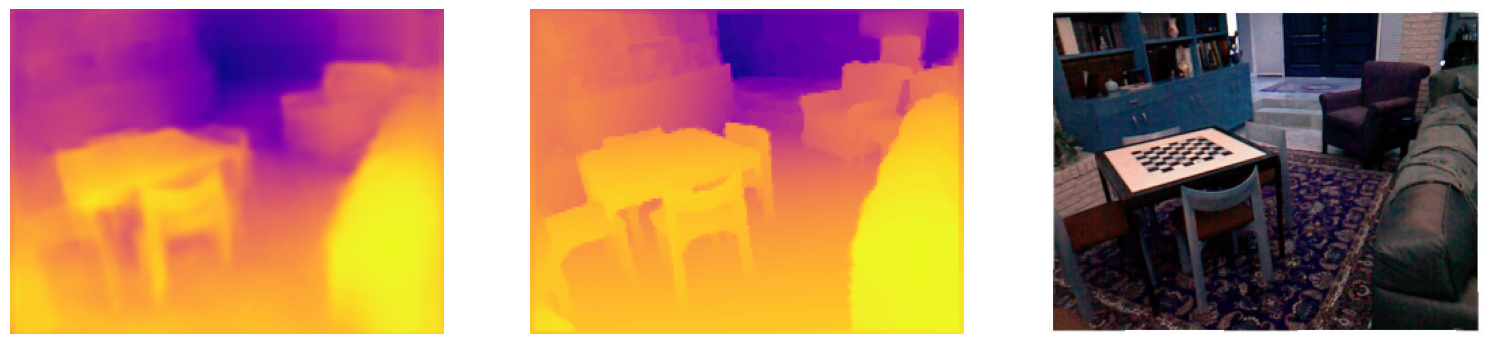

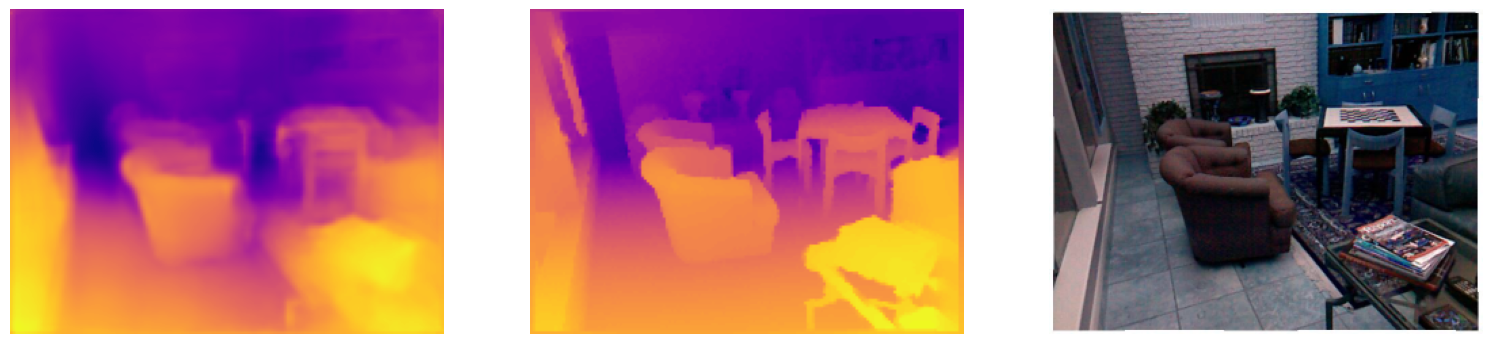

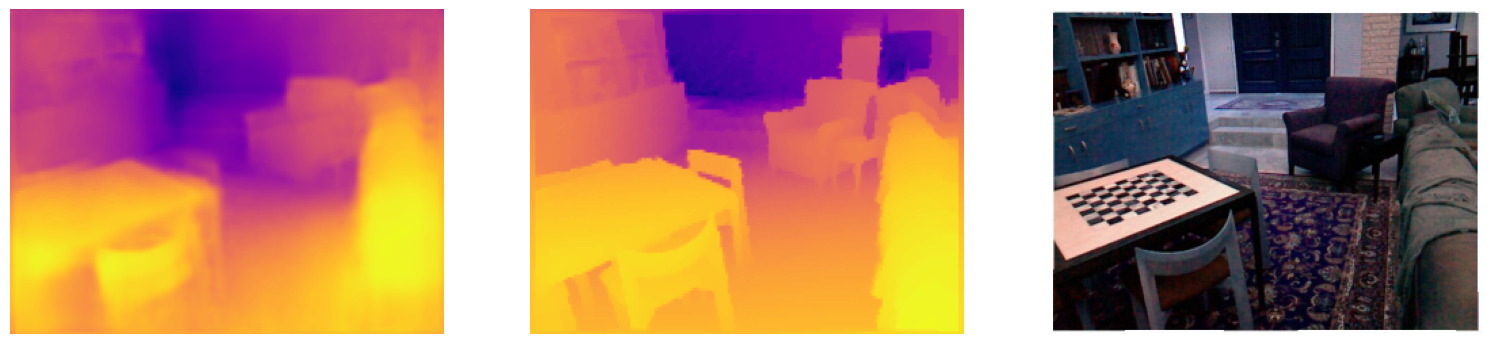

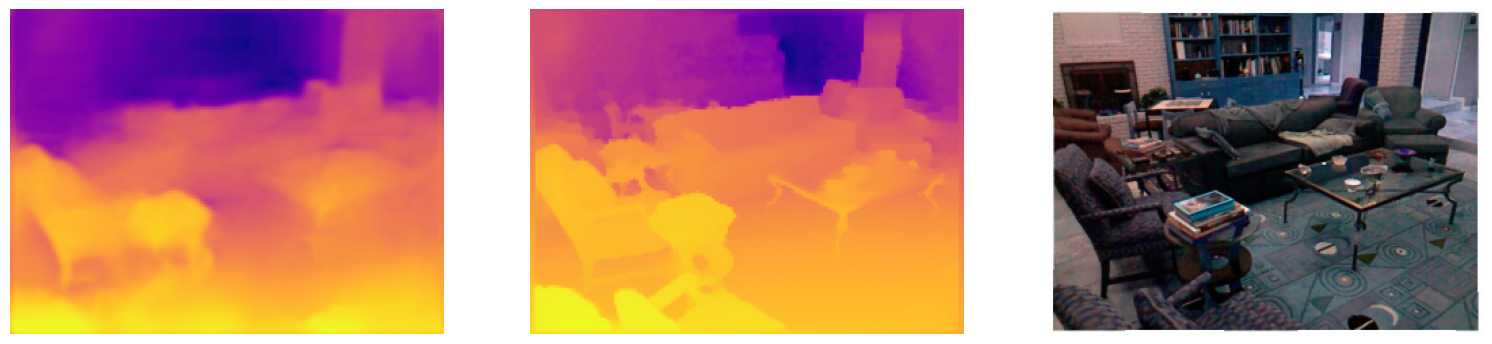

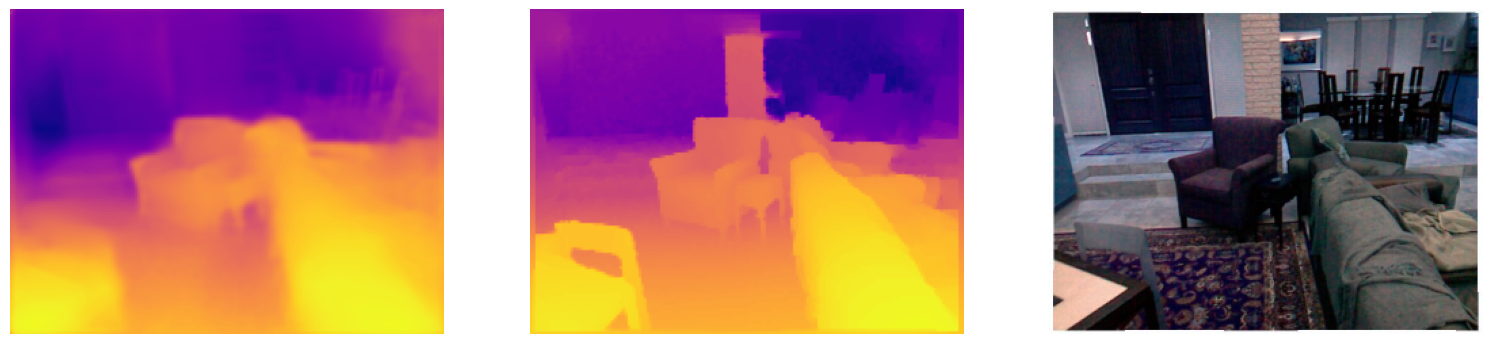

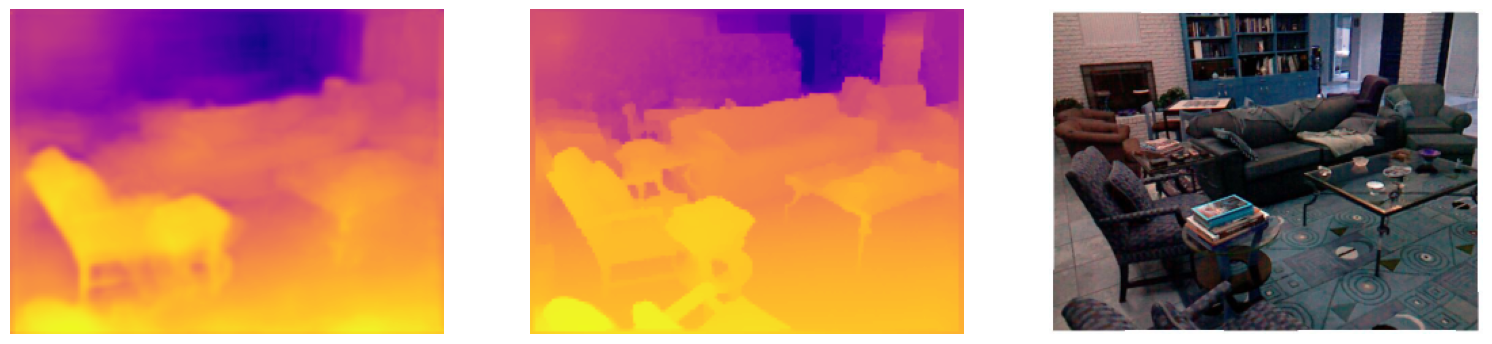

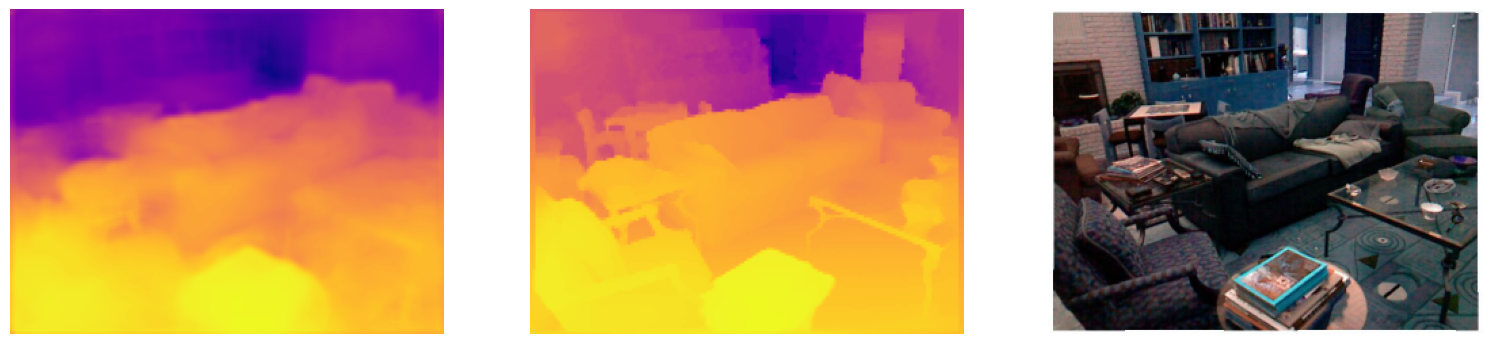

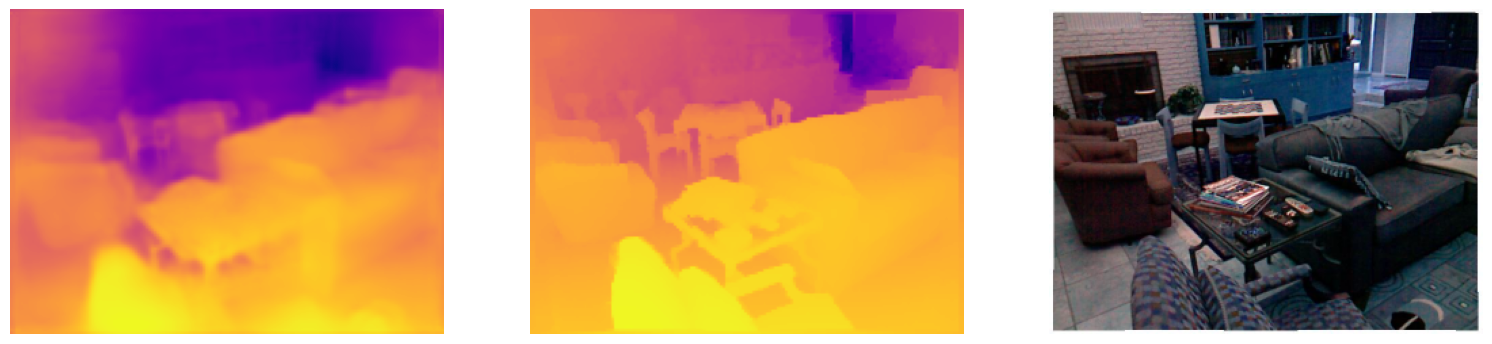

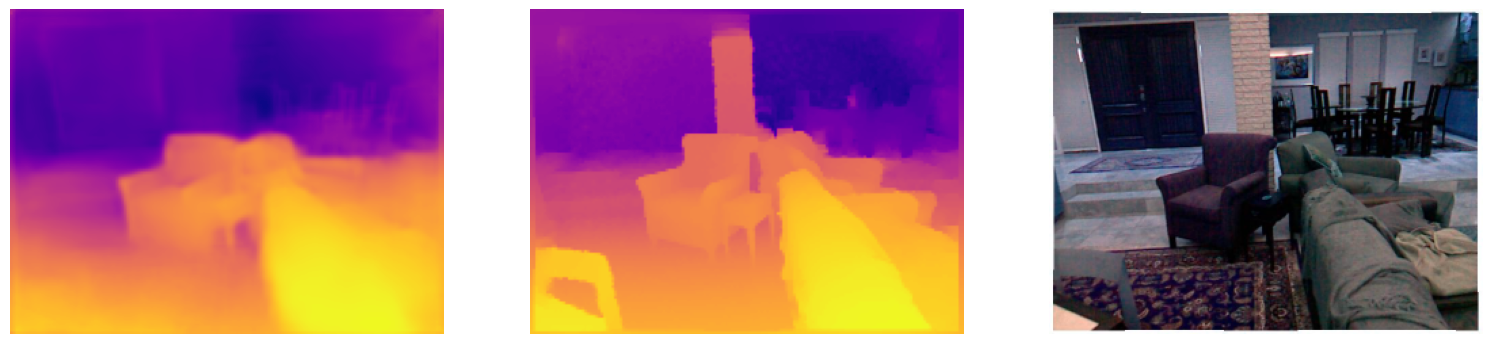

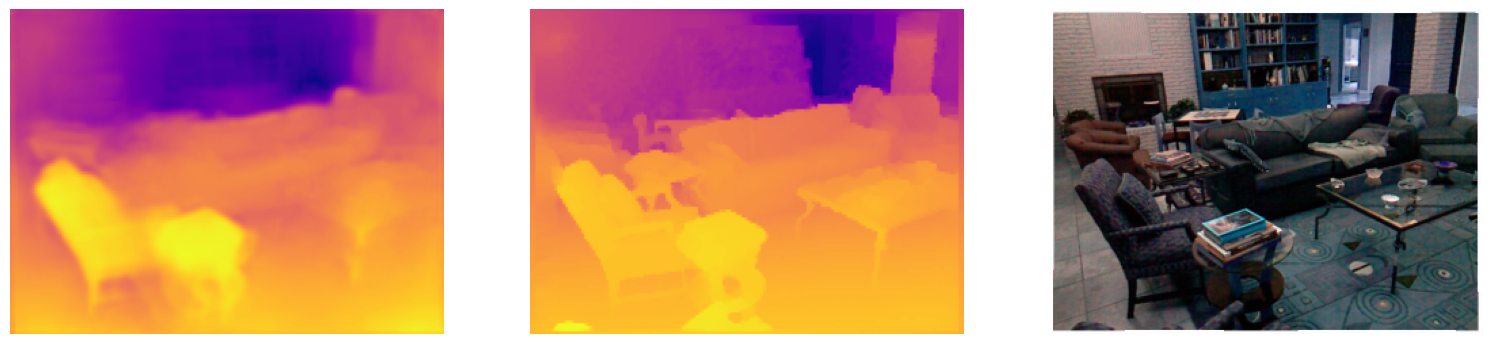

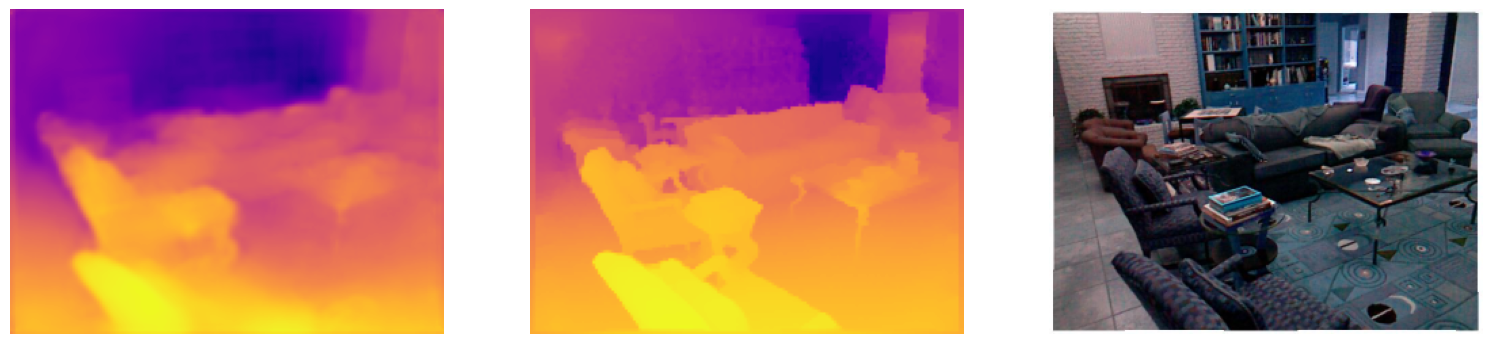

In [66]:
cmap = "plasma_r"


for i in range(len(images)):
  plt.figure(figsize=(19,10))
  pred = preds[i]
  pred = np.squeeze(pred, axis=-1)
  plt.subplot(1,3,1)
  plt.axis("off")
  plt.imshow(pred, cmap=plt.get_cmap(cmap))

  plt.subplot(1,3,2)
  plt.axis("off")
  img = labels[i]
  img = np.squeeze(img, axis=-1)
  plt.imshow(img, cmap=plt.get_cmap(cmap))

  plt.subplot(1,3,3)
  plt.axis("off")
  img1 = images[i]
  plt.imshow(img1)

  plt.show()

In [67]:
from tensorflow.keras.models import model_from_json
from tensorflow.keras import models
model.save(f"/kaggle/working/model_trained", save_format="tf")
print("Saved model to disk")

Saved model to disk


In [68]:
import zipfile

# Ruta completa de la carpeta del modelo guardado
folder_path = f"/kaggle/working/model_trained"

# Comprimir la carpeta en un archivo ZIP
with zipfile.ZipFile('/kaggle/working/model_trained.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, folder_path)
            zipf.write(file_path, arcname)

In [69]:
# Convertir el modelo a TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Guardar el modelo TFLite en un archivo
with open(f"modelo.tflite", "wb") as f:
    f.write(tflite_model)

print("Modelo convertido a TensorFlow Lite y guardado en 'modelo.tflite'")

Modelo convertido a TensorFlow Lite y guardado en 'modelo.tflite'
